In [3]:
import matplotlib.image as mpimg   
import cv2                                         

In [4]:
import os
import math

In [5]:
import numpy as np 
import matplotlib.pyplot as plt
import math
import pandas as pd
from pathlib import Path

In [6]:
import colour as cl
from scipy import signal as sp
from numpy.linalg import norm

In [7]:
import seaborn as sns

In [8]:
import matplotlib.pyplot as plt

# Выделение изображений тест-полосок из снимка

Функция для размывания изображения

In [50]:
def blurImage(image_gray, num):
    kernel = np.ones((num,num),np.float32)/4                     #Blurring kernel
    #We will skip first line and first column to keep it more simple, it's zeroed out anyway.
    #now for every pixel we change it with the average of 4 pixels(as the kernel): itself, pixel to left
    #pixel up, and pixel up-left. It drifts some edges one pixel to bottom-down, but it does not matter as
    #long as we use edged picture for the future work
    res=sp.convolve2d(image_gray,kernel,mode='same')
    
    return np.round(res).astype(np.uint8)

### Загрузка изображений из локальной директории

In [364]:
strip1 = cv2.imread("imgs/patients/21032024/60_corrected/IMG_20240321_121035.jpg")

In [139]:
strip2 = cv2.imread("imgs/patients/21032024/60_corrected/IMG_20240321_120805.jpg")

In [25]:
strip3 = cv2.imread("imgs/glucose/10032024/60_corrected/IMG_20240310_171753.jpg")

In [26]:
# проблемный образец
strip4 = cv2.imread("imgs/patients/05042024/60_corrected/IMG_20240405_123911.jpg")

In [21]:
# проблемный образец, глюкоза
strip_gl = cv2.imread("imgs/glucose_calibration/10032024/60_renamed/026.jpg")

In [35]:
# проблемный образец, альбумин
strip_al = cv2.imread("imgs/albumin_calibration/01052024/60_corrected/IMG_20240501_094633.jpg")

### Пошаговые визуализации и преобразования для отладки функции выделения тест-полоски

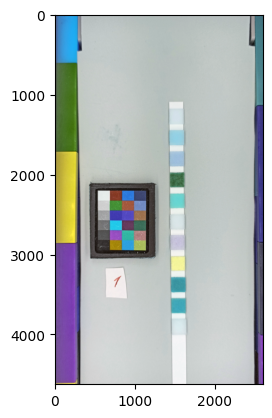

In [148]:
plt.imshow(strip4)
plt.show()

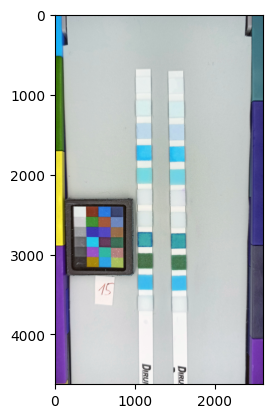

In [15]:
plt.imshow(strip_gl)
plt.show()

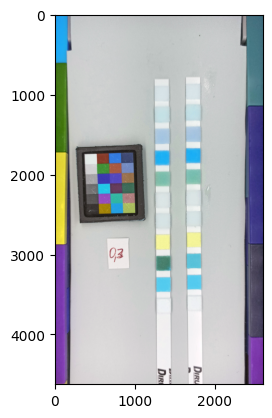

In [57]:
plt.imshow(strip_al)
plt.show()

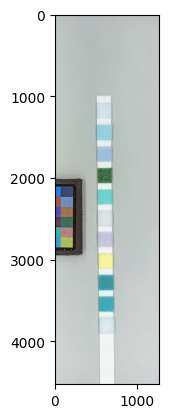

In [10]:
# обрезка
strip4a = strip4[96:,920:2200,:]
plt.imshow(strip4a)
plt.show()

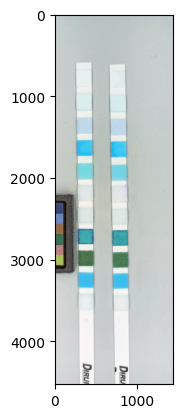

In [22]:
# обрезка
gl_a = strip_gl[96:,752:2200,:]
plt.imshow(gl_a)
plt.show()

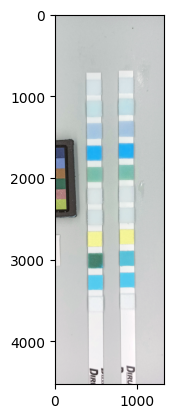

In [36]:
# обрезка
al_a = strip_al[96:,864:2200,:]
plt.imshow(al_a)
plt.show()

In [89]:
# размер
strip4.shape

(4624, 2600, 3)

In [11]:
# размер после обрезки
original_size = strip4a.shape[1], strip4a.shape[0]
original_size

(1280, 4528)

In [17]:
# размер после обрезки
original_size = gl_a.shape[1], gl_a.shape[0]
original_size

(1448, 4528)

In [37]:
original_size = al_a.shape[1], al_a.shape[0]
original_size

(1336, 4528)

In [18]:
# уменьшенный размер
im_size = (int(strip4a.shape[1]/8), int(strip4a.shape[0]/8))
im_size

(160, 566)

In [584]:
im_size = (int(gl_a.shape[1]/8), int(gl_a.shape[0]/8))
im_size

(181, 566)

Уменьшение размера

In [32]:
st4 = cv2.resize(strip4a, im_size, cv2.INTER_LINEAR)

In [33]:
st_gl = cv2.resize(gl_a, im_size, cv2.INTER_LINEAR)

In [38]:
st_al = cv2.resize(al_a, im_size, cv2.INTER_LINEAR)

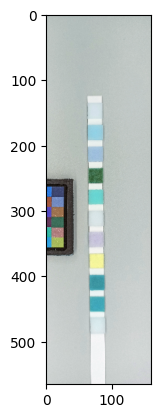

In [289]:
plt.imshow(st4)
plt.show()

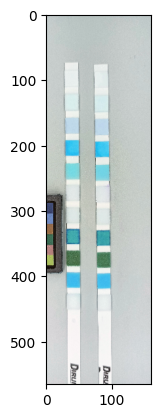

In [39]:
plt.imshow(st_gl)
plt.show()

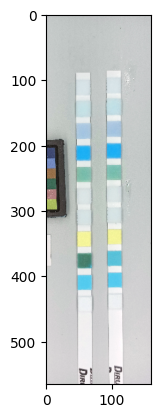

In [40]:
plt.imshow(st_al)
plt.show()

In [41]:
# перевод в градации серого
gray4 = cv2.cvtColor(st4, cv2.COLOR_BGR2GRAY)

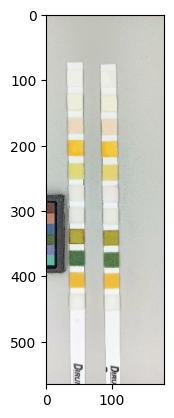

In [648]:
# перевод в RGB
st_rgb  = cv2.cvtColor(st_gl, cv2.COLOR_BGR2RGB)
plt.imshow(st_rgb)
plt.show()

In [42]:
gray_gl = cv2.cvtColor(st_gl, cv2.COLOR_BGR2GRAY)

In [43]:
gray_al = cv2.cvtColor(st_al, cv2.COLOR_BGR2GRAY)

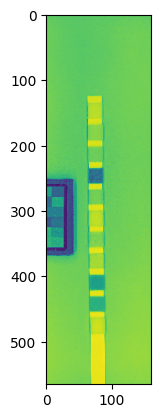

In [320]:
plt.imshow(gray4)
plt.show()

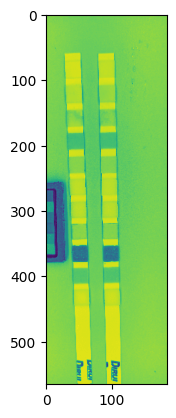

In [511]:
plt.imshow(gray_gl)
plt.show()

## Функции для выделения тест-полосок

### Функции для поиска контуров стрипов, 3 варианта

#### Функция для поиска контура тест-полоски, вариант 1

In [45]:
# рабочий вариант
def strip_contour1(gray, factor = 80):
    contours = []
    blur1 = blurImage(gray,2)
    edged1 = cv2.Canny(blur1, 40, factor) # (blur1, 40,50) если не находится контур
    blur1_2 = blurImage(edged1,3)
    blur1_3 = blurImage(blur1_2,2)
    # пороги для тест-полоски
    ret1, thresh1 = cv2.threshold(blur1_3, 15, 255, 0)
    
        # контуры для полоски
    cont1, h1 = cv2.findContours(
        image=thresh1, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    ## # определяем по размеру контур полоски (значения подобраны вручную)
    for i in range(len(cont1)):
        if ((9000 < cv2.contourArea(cont1[i])) and (20000 > cv2.contourArea(cont1[i]))):
            rct1 = cont1[i]
            indx1 = i
            contours.append(rct1)
        
    return contours  

####  Функция для поиска контура тест-полоски, вариант 2

In [46]:
# второй вариант поиска контура стрипа

def strip_contour2(resized):
    contours = []
    median = cv2.medianBlur(resized,7)
    hsv = cv2.cvtColor(median, cv2.COLOR_BGR2HSV )
    hsv_min1 = np.array((5, 0, 70), np.uint8)
    hsv_max1 = np.array((230, 17, 215), np.uint8)
    thresh_hsv = cv2.inRange(hsv, hsv_min1, hsv_max1) # применяем цветовой фильтр
    edges_hsv = cv2.Canny(thresh_hsv,10,80,apertureSize=5)
    blur_hsv = cv2.blur(edges_hsv,(2,2))
    _, thresh = cv2.threshold(blur_hsv, 15, 255, 1)
    
        # контуры для полоски
    cont_hsv, h_hsv = cv2.findContours(
        image=thresh, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    
    ## # определяем по размеру контур колорчекера (значения подобраны вручную)
    for i in range(len(cont_hsv)):
        if ((8000 < cv2.contourArea(cont_hsv[i])) and (11000 > cv2.contourArea(cont_hsv[i]))):
            rct_hsv = cont_hsv[i]
            indx_hsv = i
            contours.append(rct_hsv)
    
    return contours

#### Функция для поиска контура тест-полоски, вариант  3

In [47]:
def strip_contour3(gray):
    contours = []
    _, thresh_gray = cv2.threshold(gray, 100, 255, 3)
    edges_gray = cv2.Canny(thresh_gray,50,110,apertureSize=3)
    blur_gray = blurImage(edges_gray,2)
    blur_gray = blurImage(blur_gray,2)
    blur_gray = blurImage(blur_gray,2)
    blur_gray = blurImage(blur_gray,2)
    _, thresh_blur = cv2.threshold(blur_gray, 15, 255, 0)
        # контуры для полоски
    cont_gray, h_gray = cv2.findContours(
        image=thresh_blur, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)
    ## # определяем по размеру контур колорчекера (значения подобраны вручную)
    for i in range(len(cont_gray)):
        if ((10000 < cv2.contourArea(cont_gray[i]))) and (16000 > cv2.contourArea(cont_gray[i])):
            rct_gray = cont_gray[i]
            indx_gray = i
            contours.append(rct_gray)
    
    return contours

### Объединенная функция для выделения тест-полосок

In [48]:
# функция для выделения стрипов

def find_strip(img, num = 1):
    """
    Функция для выделения стрипов из исходного изображения
    img - исходное изображение
    num - число стрипов, которое нужно найти
    """
    
    contours = []
    img = img[96:,752:2200,:]
    original_size = img.shape[1], img.shape[0]
    im_size = (int(img.shape[1]/8), int(img.shape[0]/8))
    strips = []
    resized = cv2.resize(img, im_size, cv2.INTER_LINEAR)
    #gray_full = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    contours = strip_contour1(gray, 80)
    if len(contours) < num:
        contours1 = strip_contour1(gray, 50)
        if len(contours1) > len(contours):
            contours = contours1
    
    if len(contours) < num:
        contours2 = strip_contour2(resized)
        if len(contours2) > len(contours):
            contours = contours2
    
    if len(contours) < num:
        contours3 = strip_contour3(gray)
        if len(contours3) > len(contours):
            contours = contours3
    
    
        
    reference = (0, 1)  # вектор, задающий вертикаль
    
    for cnt in contours:
            # преобразовываем контур в прямоугольник (бокс)
        rect = cv2.minAreaRect(cnt)  # пытаемся вписать прямоугольник
        box = cv2.boxPoints(rect)  # поиск четырех вершин прямоугольника
        box = np.intp(box)  # округление координат
        box_full = box*8
        box_center_full = (int(rect[0][0])*8, int(rect[0][1])*8)
        
            # вычисление координат двух векторов, являющихся сторонам прямоугольника
        edge1 = np.intp((box[1][0] - box[0][0], box[0][1] - box[1][1]))
        edge2 = np.intp((box[2][0] - box[1][0], box[2][1] - box[1][1]))
        
        # выясняем какой вектор больше (какая сторона больше)
        usedEdge = edge1
        if cv2.norm(edge2) > cv2.norm(edge1):
            usedEdge = edge2
            tlt = -1 # отрицательный уклон от вертикали
        else:
            tlt = 1 # положительный улон от вертикали
            
        # расчет угла поворота
            
        # вычисляем угол в радианах между длинной стороной прямоугольника и вертикалью
        a_rad = math.acos((reference[0]*usedEdge[0] + reference[1] *
                       usedEdge[1]) / (cv2.norm(reference) * cv2.norm(usedEdge)))*tlt
        # вычисляем угол в градусах
        angle = a_rad*180.0/math.pi
        
        # поворачиваем исходное изображение
        rot_mat = cv2.getRotationMatrix2D(box_center_full, angle, 1.0)
        rotated = cv2.warpAffine(
                img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
        
        # поворачиваем углы прямоугольника
        corners = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
        rotated_box = np.intp((box_full-box_center_full) @ corners + box_center_full)  
        
            # вычисляем границы для кропа
        y_top = np.min(np.array([rotated_box[1][1], rotated_box[2, 1]]))
        y_bottom = np.max(np.array([rotated_box[0][1], rotated_box[3, 1]]))
        x_left = np.min(np.array([rotated_box[0][0], rotated_box[1, 0]]))
        x_right = np.max(np.array([rotated_box[2][0], rotated_box[3, 0]]))
        
        # обрезаем исходное изображение
        crop = rotated[y_top:y_bottom, x_left:x_right, :]
        
        strips.append(crop)
    
    return(strips)      

In [54]:
# применяем к снимку
t4 = find_strip(strip_gl)[0]

In [56]:
t4.shape

(3917, 257, 3)

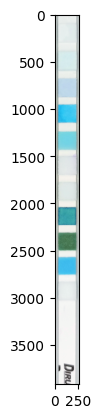

In [55]:
plt.imshow(t4)
plt.show()

Для калибраторов глюкозы

In [57]:
t_gl = find_strip(strip_gl, num = 2)

In [58]:
len(t_gl)

2

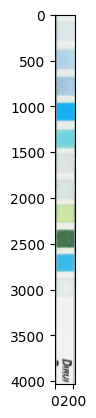

In [567]:
plt.imshow(t_gl[0])
plt.show()

## Выделение тест-полосок из изображений в заданной директории

In [638]:
# калибраторы глюкозы
# укажем путь к файлам и получим список файлов:
path = "imgs/glucose/27032024/60_corrected/"
files = os.listdir(path)

In [51]:
# калибраторы альбумина
# укажем путь к файлам и получим список файлов:
path = "imgs/albumin_calibration/01052024/60_corrected/"
files = os.listdir(path)
len(files)

54

In [642]:
# создадим в директории дня новую директорую для извлеченных стрипов (один стрип на снимке)
extracted_path = os.path.join(str(Path(path).parents[0]), (Path(path).parts[-1] + '_strips'))
os.mkdir(extracted_path)

In [52]:
# создадим в директории дня новую директорую для извлеченных стрипов (два стрипа, первый из двух)
extracted_path1 = os.path.join(str(Path(path).parents[0]), (Path(path).parts[-1] + '_strips'))
os.mkdir(extracted_path1)

In [53]:
# создадим в директории дня новую директорую для извлеченных стрипов (два стрипа, второй из двух)
extracted_path2 = os.path.join(str(Path(path).parents[0]), (Path(path).parts[-1] + '_strips2'))
os.mkdir(extracted_path2)

### Функция для извлечения и записи изображений тест-полосок

In [219]:
# функция для извлечения и сохранения изображений одиночных тест-полосок
def strip_extraction(path, filename, new_path, num = 1):
    """
    Функция для выделения изображений полосок для файлов в директории
    path - путь к файлам
    filename - имя исходного файла
    new_path - путь для сохранения корректированных файлов
    """
    img = cv2.imread(path + filename) # читаем файл
    strips = find_strip(img, num) # извлекаем изображения полосок
    
    if len(strips) > 0:
        cv2.imwrite(os.path.join(new_path ,filename), strips[0])
        
        if len(strips) >1:
            cv2.imwrite(os.path.join(new_path , ('2_' +filename)), strips[1])
            
    
    return strips    

In [54]:
# функция для извлечения и сохранения изображений тест-полосок
# для наборов с двумя тест-полосками - калибраторы глюкозы или альбумина
def strip_extraction2(path, filename, new_path1, new_path2, num_strips = 2):
    """
    Функция для выделения изображений полосок для файлов в директории
    path - путь к файлам
    filename - имя исходного файла
    new_path - путь для сохранения корректированных файлов
    """
    img = cv2.imread(path + filename) # читаем файл
    strips = find_strip(img, num = num_strips) # извлекаем изображения полосок
    
    if len(strips) > 0:
        cv2.imwrite(os.path.join(new_path1 ,filename), strips[0])
        
        if len(strips) >1:
            cv2.imwrite(os.path.join(new_path2 , filename), strips[1])
            
    
    return strips    

In [643]:
# для одной тест-полоски на снимке
for item in files:
    strips_1 = strip_extraction(path, item, extracted_path)

In [55]:
# для двух тест-полосок на снимке
for item in files:
    strips_1 = strip_extraction2(path, item, extracted_path1, extracted_path2, num_strips = 2)

### Ячейки для отладки функций выделения контуров

#### Вариант 1

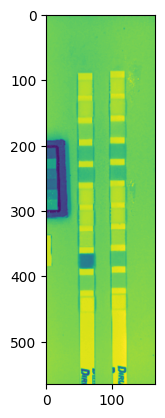

In [65]:
# шаг1, размывание
blur1 = blurImage(gray_al,2)
plt.imshow(blur1)
plt.show()

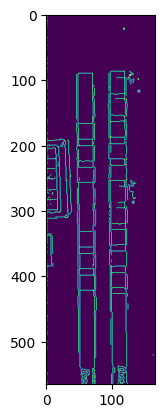

In [68]:
# шаг 2, поиск границ
edged1 = cv2.Canny(blur1, 40, 80)
plt.imshow(edged1)
plt.show()

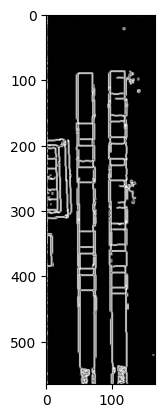

In [69]:
# шаг 3, размывание
blur12 = blurImage(edged1,3)
plt.imshow(blur12,  cmap="gray")
plt.show()

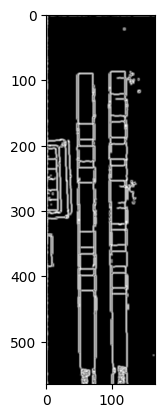

In [70]:
# шаг 4, размывание
blur13 = blurImage(blur12,2)
plt.imshow(blur13, cmap="gray")
plt.show()

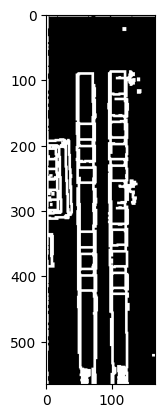

In [71]:
# щаг 5, бинаризация, пороги для тест-полоски
ret1, thresh1 = cv2.threshold(blur13, 15, 255, 0)
plt.imshow(thresh1, cmap='gray')
plt.show()

In [72]:
    # контуры для полоски
cont1, h1 = cv2.findContours(
        image=thresh1, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

In [73]:
## # определяем по размеру контур колорчекера (значения подобраны вручную)
for i in range(len(cont1)):
    if ((9500 < cv2.contourArea(cont1[i])) and (14000 > cv2.contourArea(cont1[i]))):
        rct1 = cont1[i]
        indx1 = i
        print(cv2.contourArea(rct1))
        print(indx1)

11488.0
3
11872.5
16


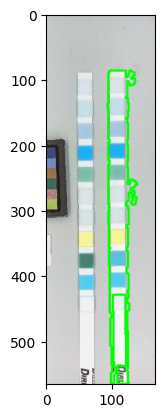

In [75]:
sel = st_al.copy()
    # получаем изображение с наложенным контуром колорчекера
selected = cv2.drawContours(image=sel, contours=cont1, contourIdx=16, color=(
        0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
plt.imshow(selected)
plt.show()

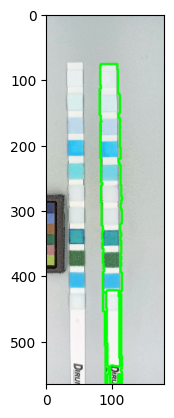

In [606]:
plt.imshow(selected)
plt.show()

#### Вариант 2

In [76]:
cnt2_4 = strip_contour2(st_al)

In [77]:
len(cnt2_4)

1

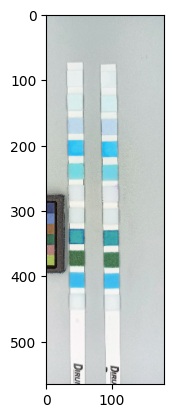

In [610]:
plt.imshow(st_gl)
plt.show()

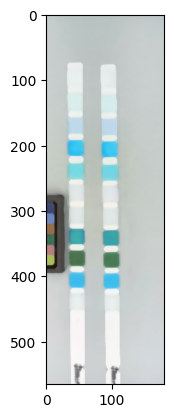

In [613]:
# шаг 1
tst = cv2.medianBlur(st_gl,7)
plt.imshow(tst)
plt.show()

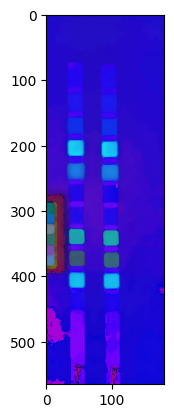

In [612]:
# шаг 2
hsv = cv2.cvtColor(tst, cv2.COLOR_BGR2HSV )
plt.imshow(hsv)
plt.show()

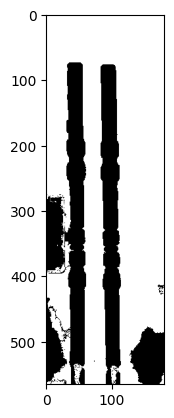

In [623]:
# шаг 3
hsv_min1 = np.array((5, 0, 30), np.uint8)
hsv_max1 = np.array((230, 17, 215), np.uint8)
thresh_hsv = cv2.inRange(hsv, hsv_min1, hsv_max1) # применяем цветовой фильтр
plt.imshow(thresh_hsv, cmap='gray')
plt.show()

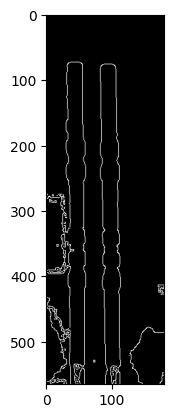

In [624]:
# шаг 4
edges_hsv = cv2.Canny(thresh_hsv,10,80,apertureSize=5)
plt.imshow(edges_hsv, cmap='gray')
plt.show()

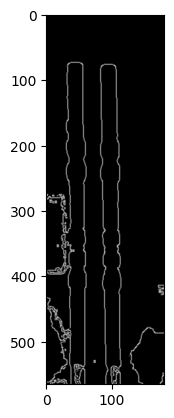

In [625]:
# шаг 5
bl_hsv = cv2.blur(edges_hsv,(2,2))
plt.imshow(bl_hsv, cmap='gray')
plt.show()

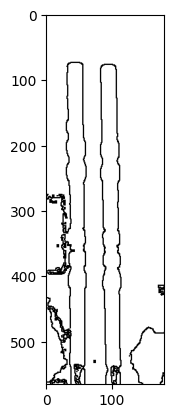

In [626]:
# шаг 6 пороги для тест-полоски
_, thresh2 = cv2.threshold(bl_hsv, 15, 255, 1)
plt.imshow(thresh2, cmap='gray')
plt.show()

In [627]:
cont_hsv, h_hsv = cv2.findContours(
        image=thresh2, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

In [630]:
## # определяем по размеру контур колорчекера (значения подобраны вручную)
for i in range(len(cont_hsv)):
    if ((8000 < cv2.contourArea(cont_hsv[i])) and (11000 > cv2.contourArea(cont_hsv[i]))):
        rct_hsv = cont_hsv[i]
        indx_hsv = i
        print(cv2.contourArea(rct_hsv))
        print(indx_hsv)

9552.0
75


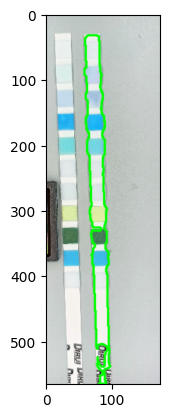

In [464]:
sel2 = st_gl.copy()
    # получаем изображение с наложенным контуром колорчекера
selected2 = cv2.drawContours(image=sel2, contours=cont_hsv, contourIdx=53, color=(
        0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
plt.imshow(selected2)
plt.show()

#### Вариант 3 поиска контуров

In [78]:
cnt_gray = strip_contour3(gray_al)
len(cnt_gray)

2

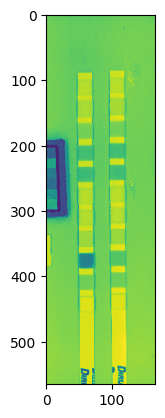

In [80]:
# gray4 = cv2.cvtColor(strip4, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_al)
plt.show()

In [437]:
gray4.shape

(566, 160)

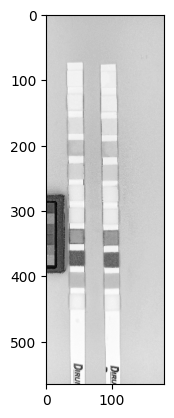

In [634]:
plt.imshow(gray_gl, cmap='gray')
plt.show()

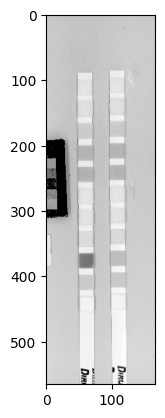

In [81]:
# пороги для тест-полоски
ret3_1, thresh3_1 = cv2.threshold(gray_al, 100, 255, 3)
plt.imshow(thresh3_1, cmap='gray')
plt.show()

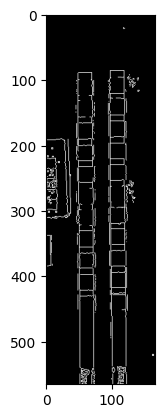

In [82]:
edges3 = cv2.Canny(thresh3_1,50,110,apertureSize=3)
plt.imshow(edges3, cmap='gray')
plt.show()

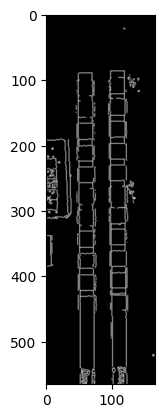

In [83]:
blur3_1 = blurImage(edges3,2)
plt.imshow(blur3_1, cmap="gray")
plt.show()

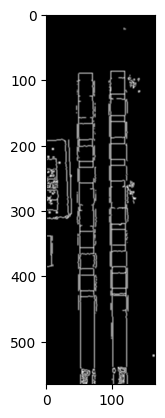

In [84]:
blur3_2 = blurImage(blur3_1,2)
plt.imshow(blur3_2, cmap="gray")
plt.show()

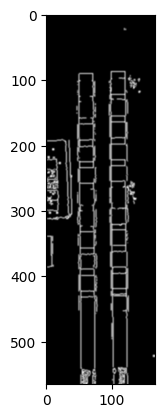

In [85]:
blur3_3 = blurImage(blur3_2,2)
plt.imshow(blur3_3, cmap="gray")
plt.show()

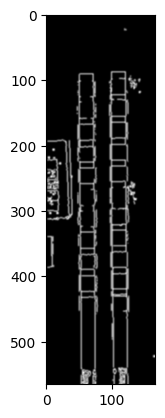

In [86]:
blur3_4 = blurImage(blur3_3,2)
plt.imshow(blur3_4, cmap="gray")
plt.show()

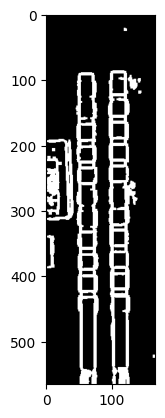

In [87]:
# пороги для тест-полоски
ret3, thresh3 = cv2.threshold(blur3_4, 15, 255, 0)
plt.imshow(thresh3, cmap='gray')
plt.show()

In [88]:
    # контуры для полоски
cont3, h3 = cv2.findContours(
        image=thresh3, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_SIMPLE)

In [89]:
## # определяем по размеру контур колорчекера (значения подобраны вручную)
for i in range(len(cont3)):
    if ((9000 < cv2.contourArea(cont3[i]))) and (20000 > cv2.contourArea(cont3[i])):
        rct3 = cont3[i]
        indx3 = i
        print(cv2.contourArea(rct3))
        print(indx3)


13047.0
16
13342.0
31


In [93]:
sel3 = st_al.copy()
    # получаем изображение с наложенным контуром колорчекера
selected3 = cv2.drawContours(image=sel3, contours=cont3, contourIdx=31, color=(
        0, 255, 0), thickness=2, lineType=cv2.LINE_AA)

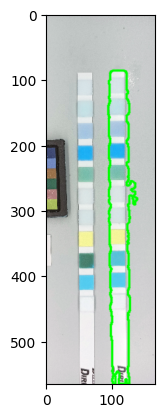

In [94]:
plt.imshow(selected3)
plt.show()

### Ячейки для отладки поворота прямоугольного контура и вырезания тест-полоски по контуру

In [481]:
rect = cv2.minAreaRect(rct1)  # пытаемся вписать прямоугольник
box = cv2.boxPoints(rect)  # поиск четырех вершин прямоугольника
box = np.intp(box)  # округление координат
box_center = (int(rect[0][0]), int(rect[0][1]))        

In [482]:
box

array([[ 65, 117],
       [ 96, 116],
       [113, 551],
       [ 81, 553]], dtype=int64)

In [63]:
box_full = box*8
box_full

array([[1216, 4608],
       [1232,  800],
       [1472,  808],
       [1456, 4616]], dtype=int64)

In [64]:
box_center

(168, 339)

In [65]:
box_center_bottom = box_center[0], im_size[1]
box_center_bottom

(168, 578)

In [66]:
box_center_full = box_center[0]*8, box_center[1]*8

In [67]:
box_center_full

(1344, 2712)

In [68]:
box_center_full = (int(rect[0][0])*8, int(rect[0][1])*8)   
box_center_full

(1344, 2712)

In [69]:
box_center_full_bottom = box_center_full[0], original_size[1]
box_center_full_bottom

(1344, 4624)

In [70]:
    # вычисление координат двух векторов, являющихся сторонам прямоугольника
edge1 = np.intp((box[1][0] - box[0][0], box[0][1] - box[1][1]))
edge2 = np.intp((box[2][0] - box[1][0], box[2][1] - box[1][1]))

In [71]:
# выясняем какой вектор больше (какая сторона больше)
usedEdge = edge1
if cv2.norm(edge2) > cv2.norm(edge1):
    usedEdge = edge2
    tlt = -1 # отрицательный уклон от вертикали
else:
    tlt = 1 # положительный улон от вертикали
reference = (0, 1)  # вектор, задающий вертикаль

In [72]:
    # расчет угла поворота
    # вычисляем угол в градусах между самой длинной стороной прямоугольника и вертикалью
angle = 180.0/math.pi * \
    math.acos((reference[0]*usedEdge[0] + reference[1] *
                usedEdge[1]) / (cv2.norm(reference) * cv2.norm(usedEdge)))*tlt

In [75]:
angle = a_rad*180/math.pi

In [76]:
angle

0.24073715272232246

In [74]:
 # вычисляем угол в радианах
a_rad = math.acos((reference[0]*usedEdge[0] + reference[1] *
                       usedEdge[1]) / (cv2.norm(reference) * cv2.norm(usedEdge)))*tlt

In [418]:
a_rad = angle/180*math.pi
a_rad

-0.019566974062314564

In [375]:
a_rad

-0.01956697406231456

In [77]:
rot_mat_full = cv2.getRotationMatrix2D(box_center_full, angle, 1.0)
rotated_full = cv2.warpAffine(
        strip1, rot_mat_full, strip1.shape[1::-1], flags=cv2.INTER_LINEAR)

In [78]:
rot_mat_full_bottom = cv2.getRotationMatrix2D(box_center_full_bottom, angle*tlt, 1.0)
rotated_full_bottom = cv2.warpAffine(
        strip1, rot_mat_full_bottom, strip1.shape[1::-1], flags=cv2.INTER_LINEAR)

In [411]:
rot_mat_full

array([[  9.99808573e-01,  -1.95657255e-02,   5.04867470e+01],
       [  1.95657255e-02,   9.99808573e-01,  -2.42394922e+01]])

In [356]:
rot_mat_full_bottom

array([[  9.99808573e-01,  -1.95657255e-02,   9.07138786e+01],
       [  1.95657255e-02,   9.99808573e-01,  -2.38459180e+01]])

In [234]:
    # поворачиваем изображение по центру прямоугольника
    # def rotate_around_box(image, angle, box_center):
rot_mat = cv2.getRotationMatrix2D(box_center, angle*tlt, 1.0)
rotated = cv2.warpAffine(
        strip, rot_mat, strip.shape[1::-1], flags=cv2.INTER_LINEAR)


In [313]:
rot_mat_full = cv2.getRotationMatrix2D(box_center_full, angle*tlt, 1.0)
rotated_full = cv2.warpAffine(
        strip1, rot_mat, strip1.shape[1::-1], flags=cv2.INTER_LINEAR)

In [314]:
rot_mat_full

array([[  9.99808573e-01,  -1.95657255e-02,   5.04867470e+01],
       [  1.95657255e-02,   9.99808573e-01,  -2.42394922e+01]])

In [303]:
rot_mat_full

array([[  9.99808573e-01,  -1.95657255e-02,   9.05021602e+01],
       [  1.95657255e-02,   9.99808573e-01,  -2.20622558e+00]])

In [266]:
rot_mat_full

array([[  9.99808573e-01,  -1.95657255e-02,   2.41963891e-01],
       [  1.95657255e-02,   9.99808573e-01,  -2.47310770e+01]])

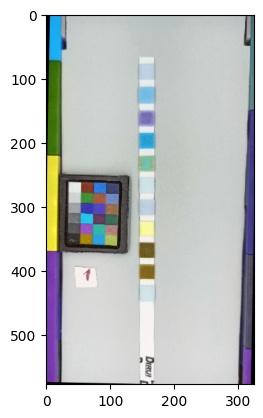

In [263]:
plt.imshow(rotated)
plt.show()

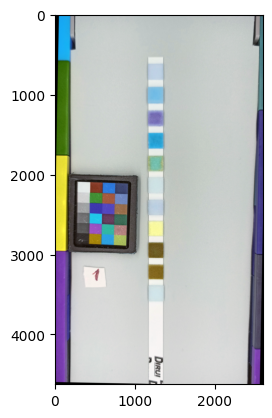

In [412]:
plt.imshow(rotated_full)
plt.show()

In [249]:
    # поворачиваем углы прямоугольника
corners = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box = np.intp((box-box_center) @ corners + box_center)

In [380]:
    # поворачиваем углы прямоугольника
corners_full = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box_full = np.intp((box_full-box_center_full) @ corners_full + box_center_full)

In [383]:
rotated_box_full

array([[1135,  525],
       [1392,  522],
       [1392, 4610],
       [1135, 4613]], dtype=int64)

In [357]:
    # поворачиваем углы прямоугольника
corners_full_bottom = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box_full_bottom = np.intp((box_full-box_center_full_bottom) @ corners_full_bottom + box_center_full_bottom)

In [250]:
rotated_box

array([[141,  65],
       [174,  65],
       [174, 576],
       [141, 576]], dtype=int64)

In [326]:
    # поворачиваем углы прямоугольника
corners1 = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box1 = np.intp((box-box_center1) @ corners + box_center1)

In [327]:
rotated_box1

array([[135,  65],
       [167,  65],
       [167, 576],
       [135, 576]], dtype=int64)

In [ ]:
    # поворачиваем углы прямоугольника
corners = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box = np.intp((box-box_center) @ corners + box_center)

In [316]:
    # поворачиваем углы прямоугольника
corners_full = np.array([[np.cos(a_rad), -np.sin(a_rad)],
                       [np.sin(a_rad), np.cos(a_rad)]])
rotated_box_full = np.intp((box_full-box_center_full) @ corners + box_center_full)

In [328]:
rotated_box

array([[141,  65],
       [174,  65],
       [174, 576],
       [141, 576]], dtype=int64)

In [387]:
rotated_box1

array([[135,  65],
       [167,  65],
       [167, 576],
       [135, 576]], dtype=int64)

In [388]:
rotated_box_full

array([[1135,  525],
       [1392,  522],
       [1392, 4610],
       [1135, 4613]], dtype=int64)

In [390]:
rotated_box*8

array([[1128,  520],
       [1392,  520],
       [1392, 4608],
       [1128, 4608]], dtype=int64)

In [330]:
rotated_box1*8

array([[1080,  520],
       [1336,  520],
       [1336, 4608],
       [1080, 4608]], dtype=int64)

In [358]:
rotated_box_full_bottom

array([[1176,  525],
       [1432,  522],
       [1432, 4611],
       [1176, 4614]], dtype=int64)

In [359]:
    # вычисляем границы для кропа
y_top = np.min(np.array([rotated_box_full_bottom[1][1], rotated_box_full_bottom[2, 1]]))
y_bottom = np.max(np.array([rotated_box_full_bottom[0][1], rotated_box_full_bottom[3, 1]]))
x_left = np.min(np.array([rotated_box_full_bottom[0][0], rotated_box_full_bottom[1, 0]]))
x_right = np.max(np.array([rotated_box_full_bottom[2][0], rotated_box_full_bottom[3, 0]]))

In [413]:
    # вычисляем границы для кропа
y_top = np.min(np.array([rotated_box_full[1][1], rotated_box_full[2, 1]]))
y_bottom = np.max(np.array([rotated_box_full[0][1], rotated_box_full[3, 1]]))
x_left = np.min(np.array([rotated_box_full[0][0], rotated_box_full[1, 0]]))
x_right = np.max(np.array([rotated_box_full[2][0], rotated_box_full[3, 0]]))

In [391]:
    # вычисляем границы для кропа
y_top = np.min(np.array([rotated_box[1][1], rotated_box[2, 1]]))*8
y_bottom = np.max(np.array([rotated_box[0][1], rotated_box[3, 1]]))*8
x_left = np.min(np.array([rotated_box[0][0], rotated_box[1, 0]]))*8
x_right = np.max(np.array([rotated_box[2][0], rotated_box[3, 0]]))*8

In [290]:
    # вычисляем границы для кропа
y_top = np.min(np.array([rotated_box1[1][1], rotated_box1[2, 1]]))*8
y_bottom = np.max(np.array([rotated_box1[0][1], rotated_box1[3, 1]]))*8
x_left = np.min(np.array([rotated_box1[0][0], rotated_box1[1, 0]]))*8
x_right = np.max(np.array([rotated_box1[2][0], rotated_box1[3, 0]]))*8

In [321]:
    # вычисляем границы для кропа
y_top = np.min(np.array([rotated_box_full[1][1], rotated_box_full[2, 1]]))
y_bottom = np.max(np.array([rotated_box_full[0][1], rotated_box_full[3, 1]]))
x_left = np.min(np.array([rotated_box_full[0][0], rotated_box_full[1, 0]]))
x_right = np.max(np.array([rotated_box_full[2][0], rotated_box_full[3, 0]]))

In [414]:
crop = rotated_full[y_top:y_bottom, x_left:x_right, :]

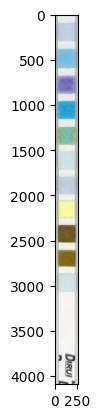

In [415]:
plt.imshow(crop)
plt.show()

In [324]:
crop_full = rotated_full[y_top:y_bottom, x_left:x_right, :]

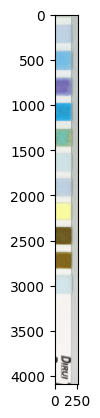

In [325]:
plt.imshow(crop_full)
plt.show()